In [2]:
from Bio import Phylo as phy
import ete3
import os
from datasketch import MinHash, MinHashLSH
import re
import subprocess
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
os.chdir('/work/site_rate/hug_et_al/')

In [2]:
tree           = phy.read('ribosomal_concat_ml_tree.tre', 'newick')
tree_taxa      = [leaf.name for leaf in tree.get_terminals()]
alignment_taxa = re.findall('^>(.*)$', open('ribosomal_concat.fasta').read(), re.M)

In [3]:
missing_tree = {}
missing_aln  = {}

for element in set(tree_taxa).difference(alignment_taxa):
    missing_tree[element] = MinHash(num_perm=1024)
    for word in element.split('_'):
        missing_tree[element].update(word.encode('utf8'))

for element in set(alignment_taxa).difference(tree_taxa):
    missing_aln[element] = MinHash(num_perm=1024)
    for word in element.split('_'):
        missing_aln[element].update(word.encode('utf8'))

In [4]:
lsh_tree = MinHashLSH(threshold=0.75, num_perm=1024)
[lsh_tree.insert(key, value) for key, value in missing_tree.items()]

lsh_aln = MinHashLSH(threshold=0.75, num_perm=1024)
[lsh_aln.insert(key, value) for key, value in missing_aln.items()]

tree_matches = set()
for tree_name, value in missing_tree.items():
    aln_values = lsh_aln.query(value)
    if not aln_values:
        continue
    tree_matches.add((tree_name, aln_values[0]))
    
aln_matches = set()
for aln_name, value in missing_aln.items():
    tree_values = lsh_tree.query(value)
    if not tree_values:
        continue
    aln_matches.add((tree_values[0], aln_name))

In [5]:
reciprocal_matches = tree_matches.intersection(aln_matches)
for tree_match, aln_match in reciprocal_matches:
    if tree_match in missing_tree:
        missing_tree.pop(tree_match)
    if aln_match in missing_aln:
        missing_aln.pop(aln_match)
print len(missing_aln)
print len(missing_tree)

8
8


In [7]:
lsh_tree = MinHashLSH(threshold=0.5, num_perm=1024)
[lsh_tree.insert(key, value) for key, value in missing_tree.items()]

lsh_aln = MinHashLSH(threshold=0.5, num_perm=1024)
[lsh_aln.insert(key, value) for key, value in missing_aln.items()]

tree_matches = set()
for tree_name, value in missing_tree.items():
    aln_values = lsh_aln.query(value)
    if not aln_values:
        continue
    tree_matches.add((tree_name, aln_values[0]))
    
aln_matches = set()
for aln_name, value in missing_aln.items():
    tree_values = lsh_tree.query(value)
    if not tree_values:
        continue
    aln_matches.add((tree_values[0], aln_name))

In [9]:
reciprocal_matches.update(tree_matches.intersection(aln_matches))
for tree_match, aln_match in reciprocal_matches:
    if tree_match in missing_tree:
        missing_tree.pop(tree_match)
    if aln_match in missing_aln:
        missing_aln.pop(aln_match)
print len(missing_aln)
print len(missing_tree)

3
3


In [12]:
reciprocal_matches.add(('Bacteria_Omnitrophica_WOR-2_uncultured_SMTZ_29',
                        'Bacteria_WOR_2_uncultured_SMTZ_29'))
reciprocal_matches.add(('Bacteria_CPR_Peregrinibacteria_CG_PER_02',
                        'Bacteria_Peregrinibacteria_CG2_30_FULL_Peregrinibacteria_PER_44_17'))
reciprocal_matches.add(('Bacteria_Fibrobacteres_Acidobacteria_Fibrobacteres_Fibrobacteria_Fibrobacterales_CG_Fibrob_01',
                        'Bacteria_Fibrobacteres_Acidobacteria_Fibrobacteres_Fibrobacteria_Fibrobacterales_CG2_30_FULL_Fibrobacteres_45_31'))

In [20]:
for tree_name, aln_name in reciprocal_matches:
    leaf      = next(tree.find_elements(name=tree_name, terminal=True))
    leaf.name = aln_name

In [23]:
bacteria     = []
archaea      = []
eukarya      = []
for leaf in tree.get_terminals():
    if leaf.name.startswith('Bacteria'):
        bacteria.append(leaf.name)
    elif leaf.name.startswith('Archaea'):
        archaea.append(leaf.name)
    elif leaf.name.startswith('Eukaryota'):
        eukarya.append(leaf.name)

for node in tree.get_nonterminals():
    if node.comment:
        node.confidence = float(node.comment)
        node.comment = ''
    else:
        node.support = 0.0

In [25]:
outgroup = tree.common_ancestor(bacteria)
tree.root_with_outgroup(outgroup)
phy.write(tree, 'ribosomal_concat_ml_tree-regular_support.tre', 'newick')

1

In [28]:
subprocess.call('iqtree -s ribosomal_concat.fasta -te ribosomal_concat_ml_tree-regular_support.tre -nt 20 -alrt 1000 -safe -m LG+G+F -redo'.split())

0

In [5]:
supported_tree = phy.read('ribosomal_concat.fasta.treefile', 'newick')

original_support = []
alrt_support     = []
branch_length    = []
for node in supported_tree.get_nonterminals():
    if not node.name:
        continue
    tmp_supports = node.name.split('/')
    original_support.append(float(tmp_supports[0]))
    alrt_support.append(float(tmp_supports[1]))
    branch_length.append(node.branch_length)
original_support = np.asarray(original_support)
alrt_support     = np.asarray(alrt_support)

In [4]:
node.branch_length

0.033911323

(2172,)


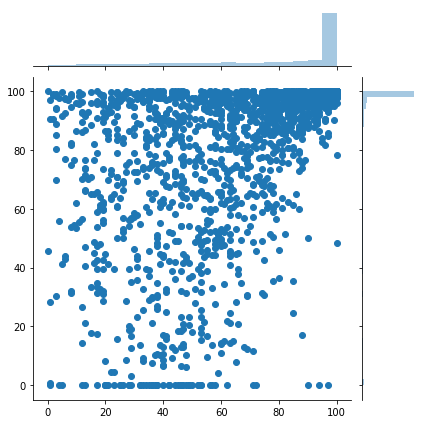

In [55]:
print alrt_support[original_support>70].shape
#sns.jointplot(original_support[original_support>70], alrt_support[original_support>70])
sns.jointplot(original_support, alrt_support)

(<seaborn.axisgrid.JointGrid at 0x1a1ad266d0>,
 <seaborn.axisgrid.JointGrid at 0x1a1afd1ad0>)

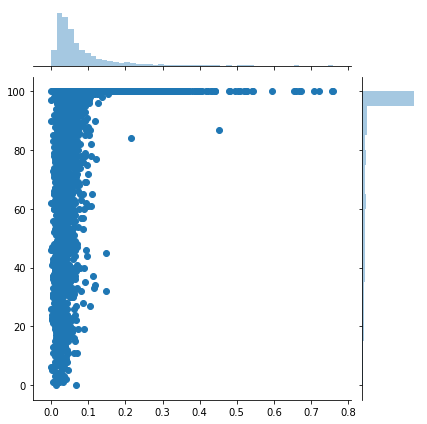

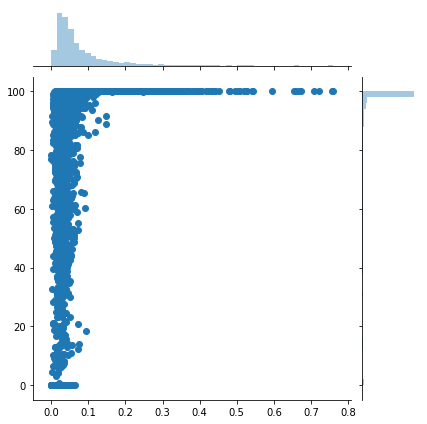

In [9]:
sns.jointplot(branch_length, original_support), sns.jointplot(branch_length, alrt_support)